In [10]:
import os
import sys
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from itertools import product
import matplotlib.pyplot as plt

# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../')))
# from models.cnn.cnn import CNNModel

In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using GPU: MPS")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: MPS


# Question 2:
## 2.1

In [13]:
def load_mnist_data(data_dir):
    def get_images_and_labels(split):
        images = []
        labels = []
        split_dir = os.path.join(data_dir, split)
        for folder in os.listdir(split_dir):
            folder_path = os.path.join(split_dir, folder)
            if os.path.isdir(folder_path):
                label = len(folder) 
                for img_name in os.listdir(folder_path):
                    img_path = os.path.join(folder_path, img_name)
                    img = Image.open(img_path).convert('L')  
                    images.append(img)
                    labels.append(label)
        return images, labels

    train_images, train_labels = get_images_and_labels('train')
    val_images, val_labels = get_images_and_labels('val')
    test_images, test_labels = get_images_and_labels('test')
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

In [14]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, task_type='classification', transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.task_type = task_type  

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        if self.task_type == 'classification':
            label = torch.tensor(len(str(label)), dtype=torch.long) 

        elif self.task_type == 'regression':
            label = torch.tensor(float(len(str(label))), dtype=torch.float)

        return image, label

In [18]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        # model.to(device)
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_accuracy = 0.0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            
            # Forward pass
            outputs = model(images)
            
            # Loss calculation
            loss = model.calculate_loss(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track the loss
            running_loss += loss.item()

            if model.task_type == 'classification':
                running_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                total += labels.size(0)

        # Calculate average loss over the entire training set
        avg_train_loss = running_loss / len(train_loader)

        if model.task_type == 'classification':
            avg_train_accuracy = running_accuracy / total
        
        # Validation step
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_accuracy = 0.0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = model.calculate_loss(outputs, labels)
                val_loss += loss.item()

                if model.task_type == 'classification':
                    val_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                    total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)

        if model.task_type == 'classification':
            avg_val_accuracy = val_accuracy / total
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

## 2.2 CNN implemenation

In [16]:
print(os.getcwd())
class CNNModel(nn.Module):
    def __init__(self, num_classes=10, task_type='classification', dropout_rate=0.5):
        super(CNNModel, self).__init__()
        
        self.task_type = task_type
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128) 
        self.fc2 = nn.Linear(128, num_classes if task_type == 'classification' else 1)

        self.dropout = nn.Dropout(p=dropout_rate)  # Add dropout layer

        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.MSELoss()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)  # Apply dropout

        if self.task_type == 'classification':
            logits = self.fc2(x)
            return logits
        else:
            regression_output = self.fc2(x)
            return regression_output

    def calculate_loss(self, outputs, labels):
        if self.task_type == 'classification':
            loss = self.classification_loss(outputs, labels)
        else:
            loss = self.regression_loss(outputs.squeeze(), labels.float()) 
        return loss

    def calculate_accuracy(self, outputs, labels):
        if self.task_type == 'classification':
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            accuracy = correct / total
            return accuracy
        else:
            return None

/Users/dikshant/Desktop/college/smai/smai-m24-assignments-pingu-73/assignments/4


In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


data_dir = '../../data/external/double_mnist'
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_mnist_data(data_dir)

train_dataset = MultiMNISTDataset(train_images, train_labels, transform=transform)
val_dataset = MultiMNISTDataset(val_images, val_labels, transform=transform)
test_dataset = MultiMNISTDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CNNModel(task_type='classification')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
train_model(model, train_loader, val_loader, optimizer, num_epochs=10)


Epoch 1/10, Train Loss: 0.0337, Train Acc: 0.9950, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


In [20]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10, task_type='classification', dropout_rate=0.5, num_conv_layers=2):
        super(CNNModel, self).__init__()
        self.task_type = task_type
        self.conv_layers = nn.ModuleList()
        
        # First convolutional layer
        self.conv_layers.append(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1))

        # Subsequent convolutional layers
        for i in range(1, num_conv_layers):
            in_channels = 32 if i == 1 else 64  # Change in_channels based on layer index
            self.conv_layers.append(nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=dropout_rate)

        # To dynamically calculate the input size for the fully connected layer
        dummy_input = torch.randn(1, 1, 28, 28)  # Modify according to input size
        conv_out_size = self._get_conv_output(dummy_input)

        # Fully connected layers
        self.fc1 = nn.Linear(conv_out_size, 128)
        self.fc2 = nn.Linear(128, num_classes if task_type == 'classification' else 1)

        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.MSELoss()

    def _get_conv_output(self, x):
        for conv in self.conv_layers:
            x = self.pool(F.relu(conv(x)))
        return x.numel()

    def forward(self, x):
        for conv in self.conv_layers:
            x = self.pool(F.relu(conv(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        if self.task_type == 'classification':
            logits = self.fc2(x)
            return logits
        else:
            regression_output = self.fc2(x)
            return regression_output
        
    def calculate_loss(self, outputs, labels):
        if self.task_type == 'classification':
            loss = self.classification_loss(outputs, labels)
        else:
            loss = self.regression_loss(outputs.squeeze(), labels.float())
        return loss

    def calculate_accuracy(self, outputs, labels):
        if self.task_type == 'classification':
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total = labels.size(0)
            accuracy = correct / total
            return accuracy
        else:
            return None

## 2.3 Hyperparameter Tuning

In [24]:
def evluate_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_accuracy = 0.0
        total_train_samples = 0

        # Training loop
        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            
            # Forward pass
            outputs = model(images)
            
            # Loss calculation
            loss = model.calculate_loss(outputs, labels)
            
            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()
            
            # Track the loss and accuracy
            running_loss += loss.item()
            if model.task_type == 'classification':
                running_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                total_train_samples += labels.size(0)

        # Average training loss and accuracy
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if model.task_type == 'classification':
            avg_train_accuracy = running_accuracy / total_train_samples
            train_accuracies.append(avg_train_accuracy)
        
        # Validation step
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_accuracy = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = model.calculate_loss(outputs, labels)
                val_loss += loss.item()

                if model.task_type == 'classification':
                    val_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                    total_val_samples += labels.size(0)

        # Average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if model.task_type == 'classification':
            avg_val_accuracy = val_accuracy / total_val_samples
            val_accuracies.append(avg_val_accuracy)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, '
                  f'Val Acc: {avg_val_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies



# Hyperparameter grid and optimizer function remain unchanged
def get_optimizer(optimizer_name, model, learning_rate):
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=learning_rate)


# Hyperparameter grid
learning_rates = [0.001, 0.0001]
dropout_rates = [0.3, 0.5]
num_conv_layers = [2, 3]
optimizers = ['adam', 'sgd']

# All possible combinations
param_combinations = list(product(learning_rates, dropout_rates, num_conv_layers, optimizers))

# Training for all different combinations
history = {}
for i, (lr, dropout, num_layers, optimizer_choice) in enumerate(param_combinations):
    print(f"Training model {i+1}/{len(param_combinations)} with LR: {lr}, Dropout: {dropout}, Layers: {num_layers}, Optimizer: {optimizer_choice}")
    
    model = CNNModel(dropout_rate=dropout, num_conv_layers=num_layers, task_type='classification').to(device)
    optimizer = get_optimizer(optimizer_choice, model, lr)

    # Call train_model to get training and validation metrics
    train_loss, val_loss, train_acc, val_acc = evluate_model(model, train_loader, val_loader, optimizer, num_epochs=10)

    # Store metrics in history
    history[(lr, dropout, num_layers, optimizer_choice)] = (train_loss, val_loss, train_acc, val_acc)


def plot_loss(history, combination):
    train_loss, val_loss, train_acc, val_acc = history[combination]
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Loss Curve - {combination}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy Curve - {combination}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


# Find the best combination based on validation accuracy
best_combination = None
best_val_acc = 0
for combination, metrics in history.items():
    _, _, _, val_acc = metrics
    if max(val_acc) > best_val_acc:
        best_val_acc = max(val_acc)
        best_combination = combination

print(f'Best model combination: {best_combination} with validation accuracy of {best_val_acc}')

# Train final model on full training set using the best hyperparameters
best_lr, best_dropout, best_layers, best_optimizer = best_combination
best_model = CNNModel(dropout_rate=best_dropout, num_conv_layers=best_layers, task_type='classification').to(device)
best_optimizer = get_optimizer(best_optimizer, best_model, best_lr)

# Train the best model on the final set (no need for evaluate_model function anymore)
evluate_model(best_model, train_loader, val_loader, best_optimizer, num_epochs=10)

# Test set evaluation using train_model (for test_loader)
# test_loss, _, test_acc, _ = evluate_model(best_model, test_loader, None, best_optimizer, num_epochs=1)  # Pass test_loader instead of val_loader and evaluate only for 1 epoch
test_loss, _, test_acc, _ = evluate_model(best_model, test_loader, test_loader, best_optimizer, num_epochs=1)

print(f'Test Accuracy: {test_acc[0]:.4f}')

Training model 1/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: adam
Epoch 1/10, Train Loss: 0.0215, Train Acc: 0.9950, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Training model 2/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: 

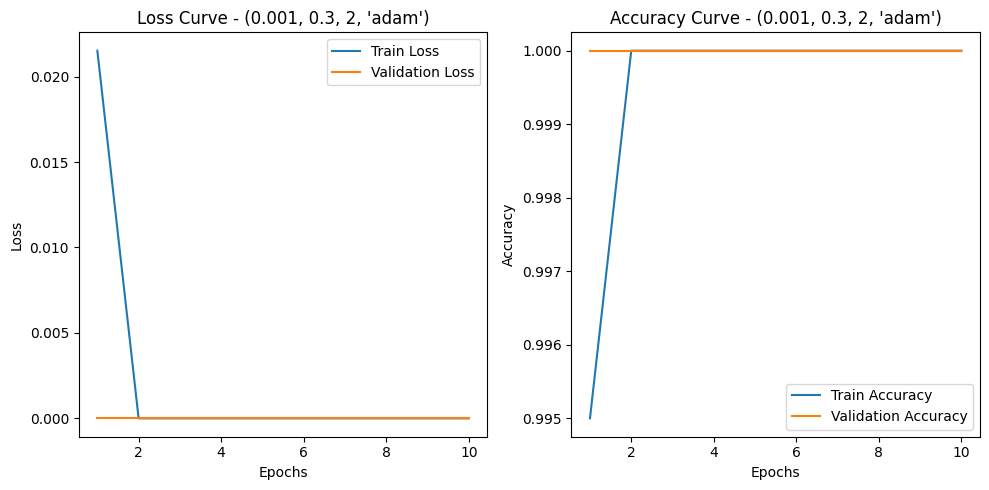

In [25]:
plot_loss(history, best_combination)

Training classification model 1/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: adam
Epoch 1/10, Train Loss: 0.0258, Train Acc: 0.9961, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Training classification model 2/16 with LR: 0.001, Dropou

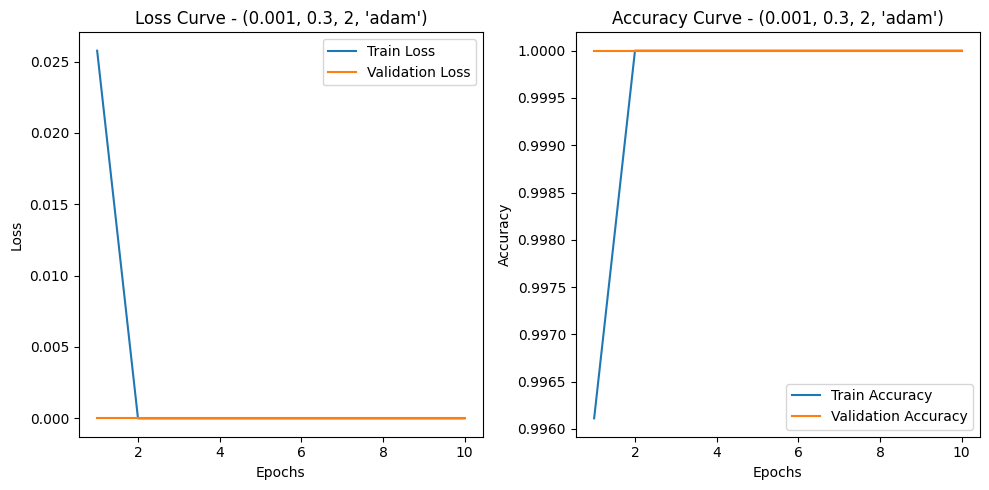

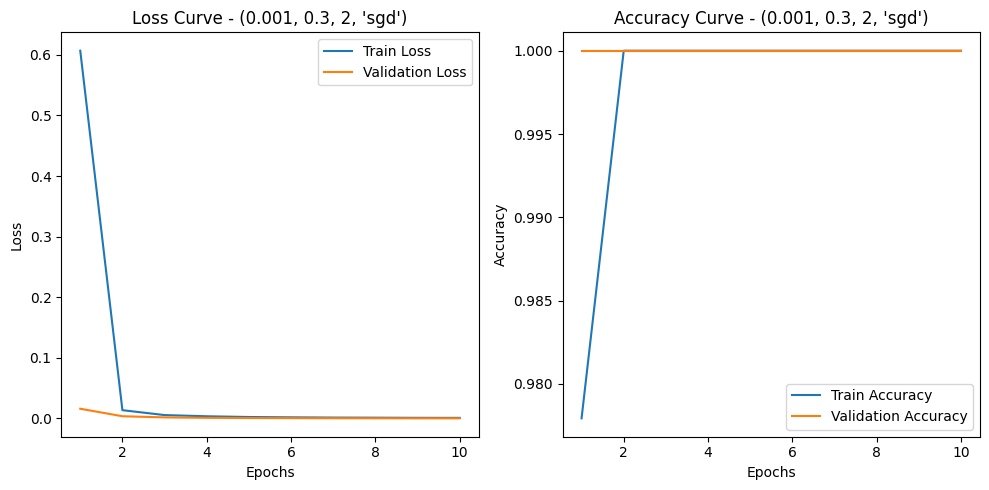

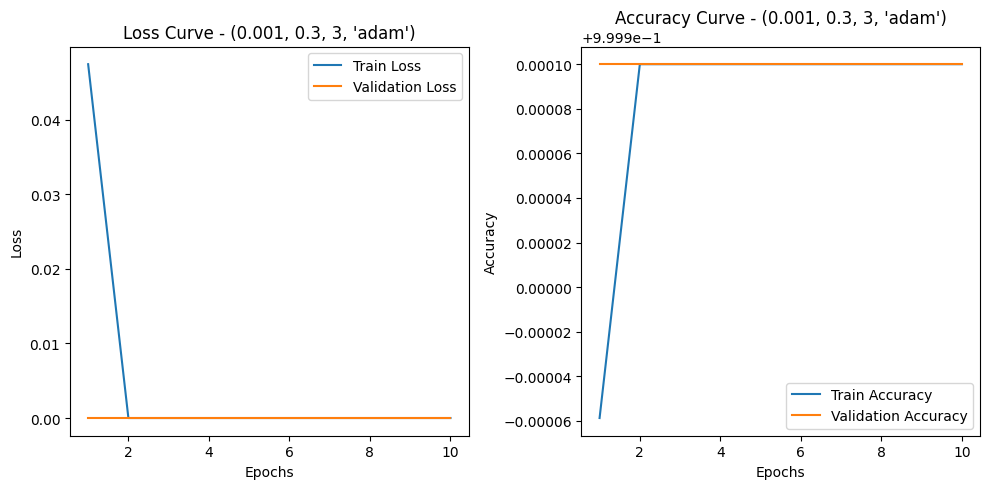

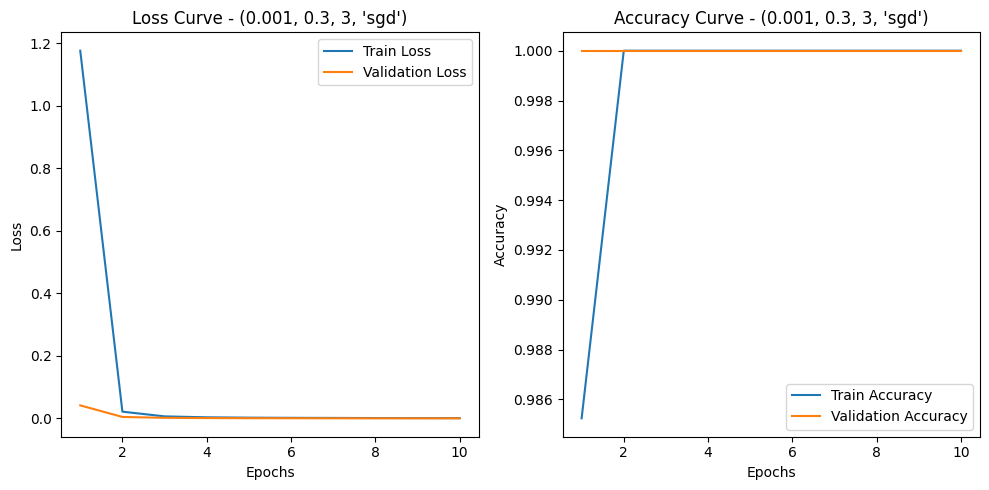

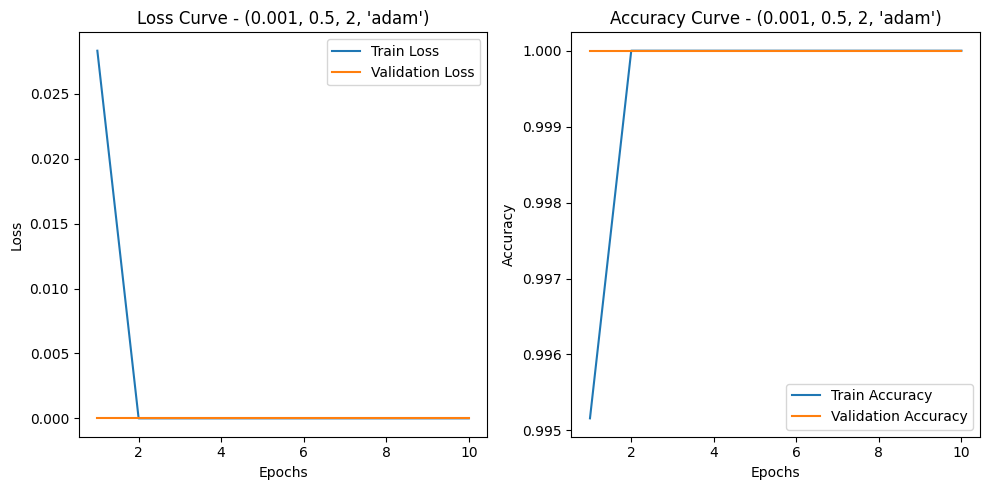

Training regression model 1/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: adam
Epoch 1/10, Train Loss: 0.0239, Val Loss: 0.0006
Epoch 2/10, Train Loss: 0.0117, Val Loss: 0.0001
Epoch 3/10, Train Loss: 0.0113, Val Loss: 0.0002
Epoch 4/10, Train Loss: 0.0103, Val Loss: 0.0002
Epoch 5/10, Train Loss: 0.0091, Val Loss: 0.0003
Epoch 6/10, Train Loss: 0.0080, Val Loss: 0.0005
Epoch 7/10, Train Loss: 0.0070, Val Loss: 0.0001
Epoch 8/10, Train Loss: 0.0059, Val Loss: 0.0001
Epoch 9/10, Train Loss: 0.0048, Val Loss: 0.0000
Epoch 10/10, Train Loss: 0.0040, Val Loss: 0.0002
Training regression model 2/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: sgd
Epoch 1/10, Train Loss: 0.0905, Val Loss: 0.0007
Epoch 2/10, Train Loss: 0.0194, Val Loss: 0.0003
Epoch 3/10, Train Loss: 0.0184, Val Loss: 0.0006
Epoch 4/10, Train Loss: 0.0173, Val Loss: 0.0002
Epoch 5/10, Train Loss: 0.0158, Val Loss: 0.0003
Epoch 6/10, Train Loss: 0.0150, Val Loss: 0.0003
Epoch 7/10, Train Loss: 0.0142, Val Loss

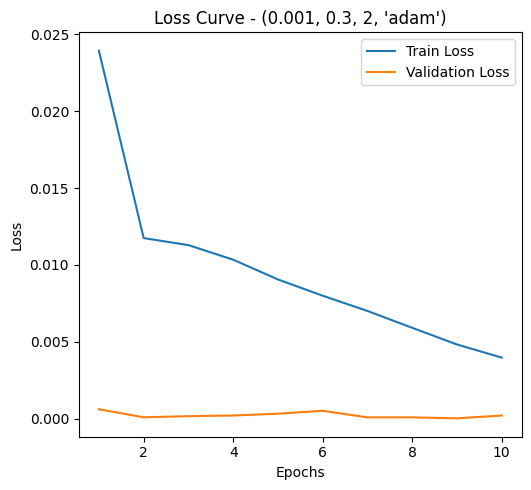

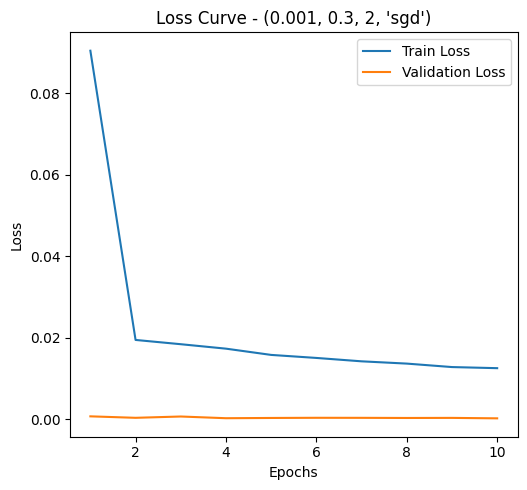

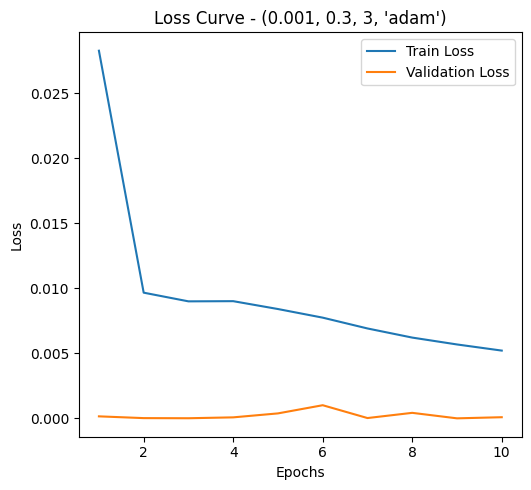

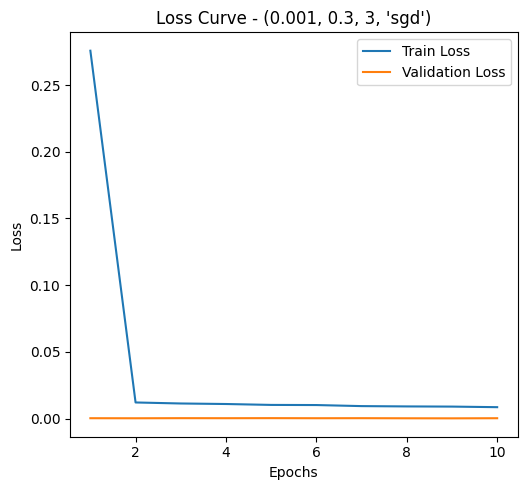

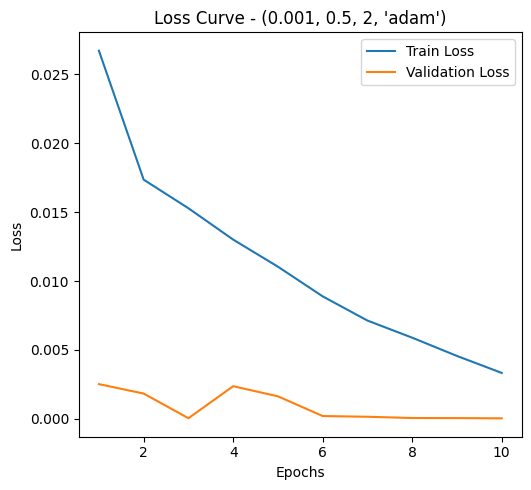

In [27]:
# Updated evaluate_model function to handle both classification and regression
def evluate_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    # print(f"running on {device}")
    # model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_accuracy = 0.0
        total_train_samples = 0

        # Training loop
        for images, labels in train_loader:
            optimizer.zero_grad()  # Zero the gradients
            
            # Forward pass
            outputs = model(images)
            
            # Loss calculation
            loss = model.calculate_loss(outputs, labels)
            
            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()
            
            # Track the loss and accuracy
            running_loss += loss.item()
            if model.task_type == 'classification':
                running_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                total_train_samples += labels.size(0)

        # Average training loss and accuracy
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if model.task_type == 'classification':
            avg_train_accuracy = running_accuracy / total_train_samples
            train_accuracies.append(avg_train_accuracy)
        
        # Validation step
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_accuracy = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = model.calculate_loss(outputs, labels)
                val_loss += loss.item()

                if model.task_type == 'classification':
                    val_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                    total_val_samples += labels.size(0)

        # Average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if model.task_type == 'classification':
            avg_val_accuracy = val_accuracy / total_val_samples
            val_accuracies.append(avg_val_accuracy)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, '
                  f'Val Acc: {avg_val_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
    
    # If classification, return accuracies too, otherwise return only losses
    if model.task_type == 'classification':
        return train_losses, val_losses, train_accuracies, val_accuracies
    else:
        return train_losses, val_losses, [], []


# Hyperparameter grid remains unchanged
def get_optimizer(optimizer_name, model, learning_rate):
    if optimizer_name == 'adam':
        return torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'sgd':
        return torch.optim.SGD(model.parameters(), lr=learning_rate)

# Modified plot_loss function to handle both tasks
def plot_loss(history, combination, task_type='classification'):
    if task_type == 'classification':
        train_loss, val_loss, train_acc, val_acc = history[combination]
    else:
        train_loss, val_loss = history[combination]
    
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Loss Curve - {combination}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if task_type == 'classification':
        # Plot accuracies for classification
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, label='Train Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.title(f'Accuracy Curve - {combination}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
    plt.tight_layout()
    plt.show()


# Hyperparameter grid
learning_rates = [0.001, 0.0001]
dropout_rates = [0.3, 0.5]
num_conv_layers = [2, 3]
optimizers = ['adam', 'sgd']

# All possible combinations
param_combinations = list(product(learning_rates, dropout_rates, num_conv_layers, optimizers))

# Training for classification models
history_classification = {}
for i, (lr, dropout, num_layers, optimizer_choice) in enumerate(param_combinations):
    print(f"Training classification model {i+1}/{len(param_combinations)} with LR: {lr}, Dropout: {dropout}, Layers: {num_layers}, Optimizer: {optimizer_choice}")
    
    model = CNNModel(dropout_rate=dropout, num_conv_layers=num_layers, task_type='classification').to(device)
    optimizer = get_optimizer(optimizer_choice, model, lr)

    # Call evluate_model to get training and validation metrics
    train_loss, val_loss, train_acc, val_acc = evluate_model(model, train_loader, val_loader, optimizer, num_epochs=10)

    # Store metrics in history
    history_classification[(lr, dropout, num_layers, optimizer_choice)] = (train_loss, val_loss, train_acc, val_acc)

# Plot loss and accuracy for classification model
for combination in param_combinations[:5]:  # Plot for the first 5 combinations
    plot_loss(history_classification, combination)


# Repeat training for regression models
history_regression = {}
for i, (lr, dropout, num_layers, optimizer_choice) in enumerate(param_combinations):
    print(f"Training regression model {i+1}/{len(param_combinations)} with LR: {lr}, Dropout: {dropout}, Layers: {num_layers}, Optimizer: {optimizer_choice}")
    
    model = CNNModel(dropout_rate=dropout, num_conv_layers=num_layers, task_type='regression')
    optimizer = get_optimizer(optimizer_choice, model, lr)

    # Call evluate_model to get training and validation metrics
    train_loss, val_loss, _, _ = evluate_model(model, train_loader, val_loader, optimizer, num_epochs=10)

    # Store metrics in history
    history_regression[(lr, dropout, num_layers, optimizer_choice)] = (train_loss, val_loss)

# Plot loss for regression models
for combination in param_combinations[:5]:  # Plot for the first 5 combinations
    plot_loss(history_regression, combination, task_type='regression')




Using device: mps
Training classification model 1/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: adam
Epoch 1/10, Train Loss: 0.0288, Train Acc: 0.9949, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 2/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 3/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 6/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 7/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 8/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 9/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 10/10, Train Loss: 0.0000, Train Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Training classification model 2/16 with

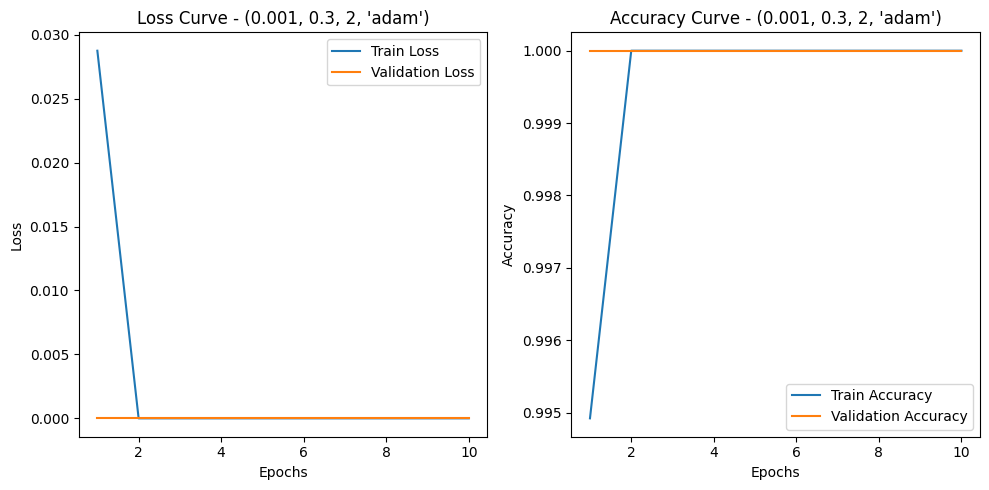

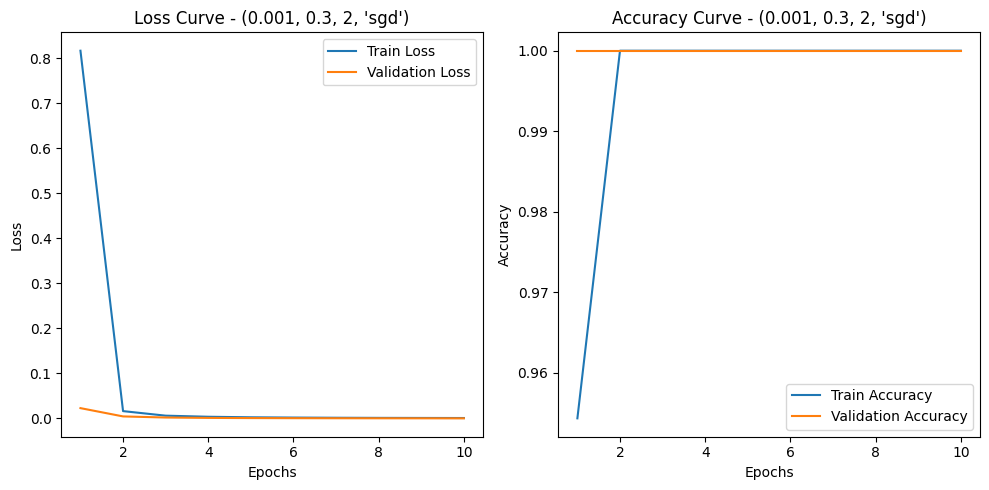

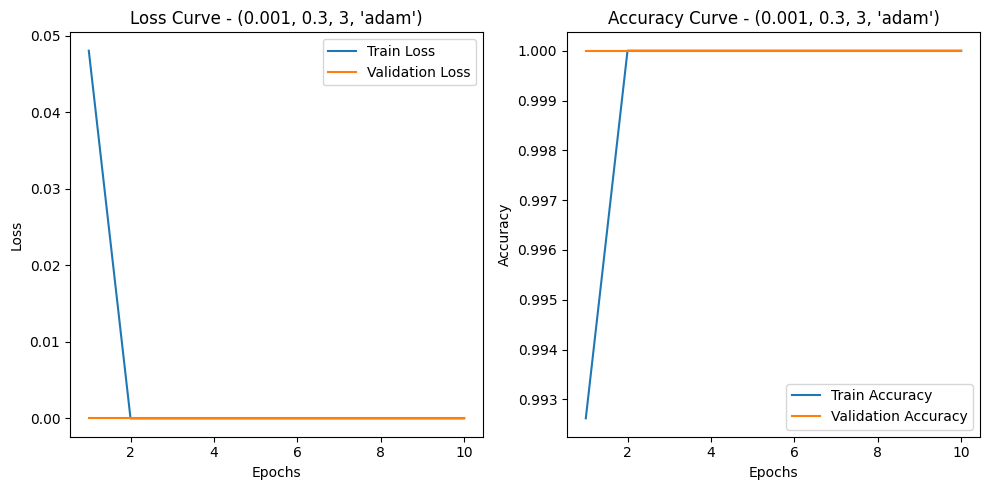

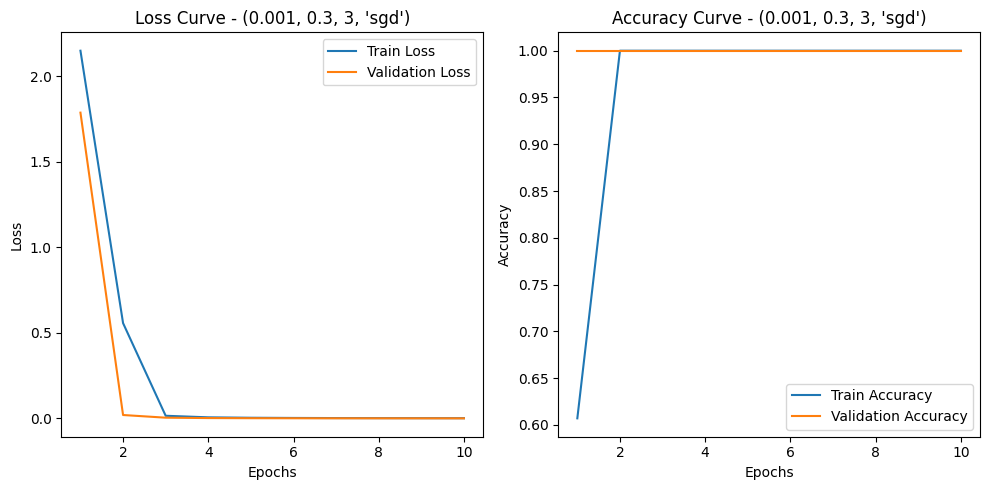

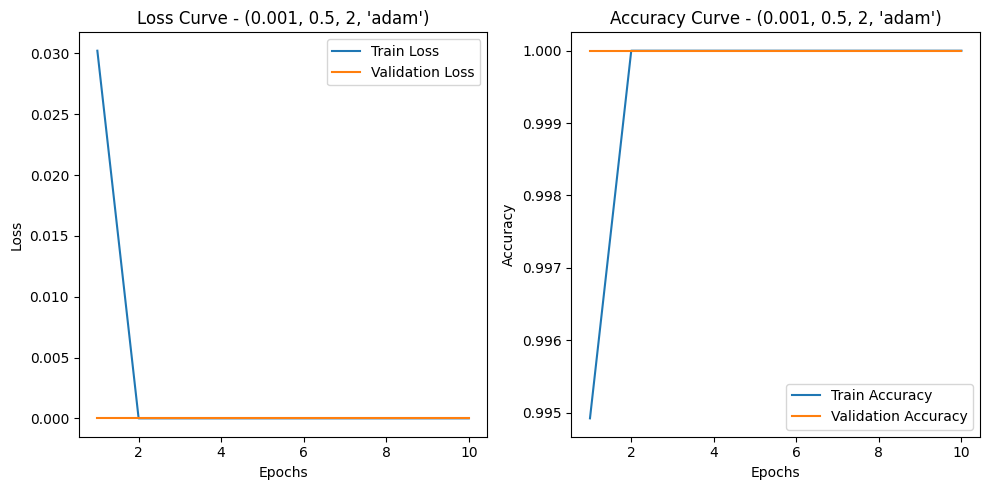

Training regression model 1/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: adam
Epoch 1/10, Train Loss: 0.0210, Val Loss: 0.0086
Epoch 2/10, Train Loss: 0.0132, Val Loss: 0.0006
Epoch 3/10, Train Loss: 0.0116, Val Loss: 0.0003
Epoch 4/10, Train Loss: 0.0107, Val Loss: 0.0001
Epoch 5/10, Train Loss: 0.0099, Val Loss: 0.0002
Epoch 6/10, Train Loss: 0.0088, Val Loss: 0.0000
Epoch 7/10, Train Loss: 0.0077, Val Loss: 0.0007
Epoch 8/10, Train Loss: 0.0066, Val Loss: 0.0000
Epoch 9/10, Train Loss: 0.0059, Val Loss: 0.0001
Epoch 10/10, Train Loss: 0.0049, Val Loss: 0.0001
Training regression model 2/16 with LR: 0.001, Dropout: 0.3, Layers: 2, Optimizer: sgd
Epoch 1/10, Train Loss: 0.0488, Val Loss: 0.0004
Epoch 2/10, Train Loss: 0.0167, Val Loss: 0.0003
Epoch 3/10, Train Loss: 0.0154, Val Loss: 0.0002
Epoch 4/10, Train Loss: 0.0149, Val Loss: 0.0005
Epoch 5/10, Train Loss: 0.0139, Val Loss: 0.0001
Epoch 6/10, Train Loss: 0.0134, Val Loss: 0.0003
Epoch 7/10, Train Loss: 0.0133, Val Loss

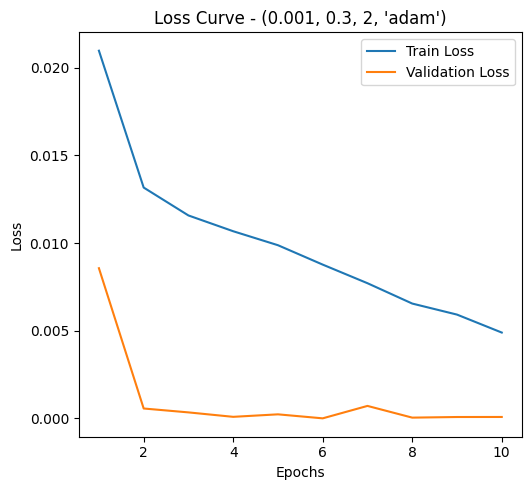

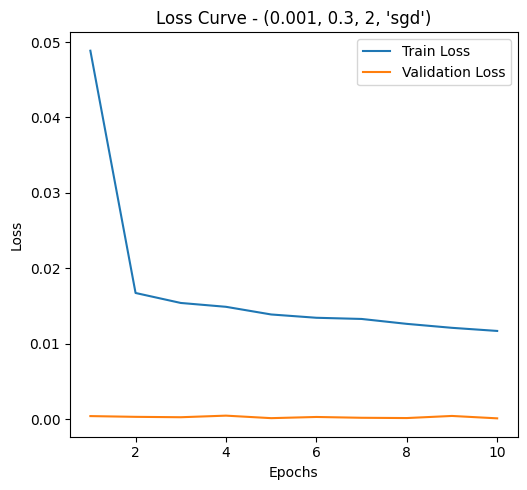

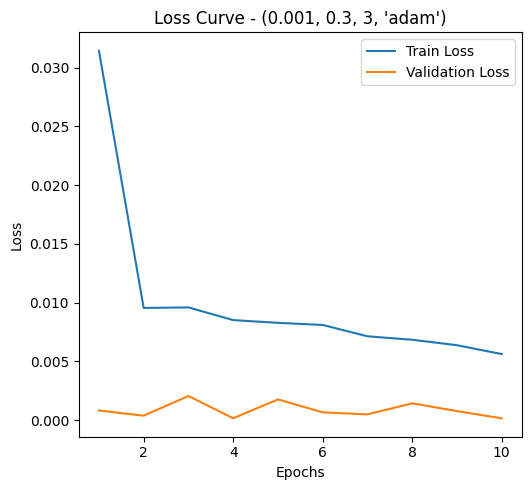

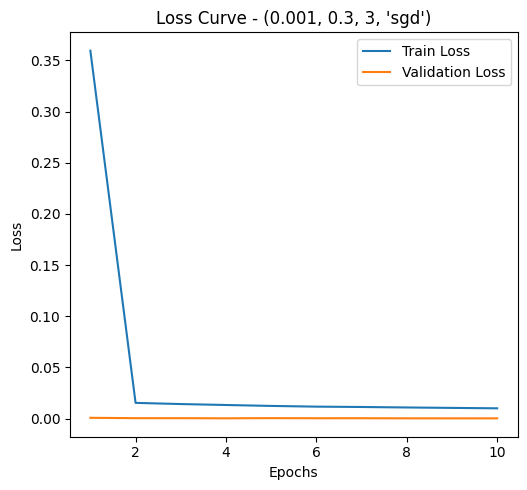

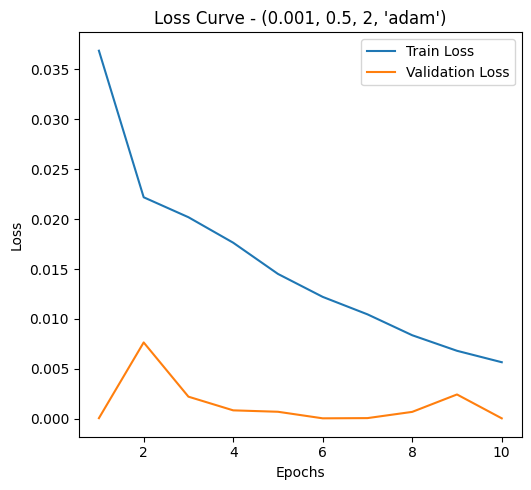

In [30]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

# Modify the evluate_model function to use GPU
def evluate_model(model, train_loader, val_loader, optimizer, num_epochs=10):
    model.to(device)  # Move the model to the GPU
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_accuracy = 0.0
        total_train_samples = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()  # Zero the gradients
            
            # Forward pass
            outputs = model(images)
            
            # Loss calculation
            loss = model.calculate_loss(outputs, labels)
            
            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()
            
            # Track the loss and accuracy
            running_loss += loss.item()
            if model.task_type == 'classification':
                running_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                total_train_samples += labels.size(0)

        # Average training loss and accuracy
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        if model.task_type == 'classification':
            avg_train_accuracy = running_accuracy / total_train_samples
            train_accuracies.append(avg_train_accuracy)
        
        # Validation step
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_accuracy = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move validation data to GPU
                outputs = model(images)
                loss = model.calculate_loss(outputs, labels)
                val_loss += loss.item()

                if model.task_type == 'classification':
                    val_accuracy += model.calculate_accuracy(outputs, labels) * labels.size(0)
                    total_val_samples += labels.size(0)

        # Average validation loss and accuracy
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if model.task_type == 'classification':
            avg_val_accuracy = val_accuracy / total_val_samples
            val_accuracies.append(avg_val_accuracy)
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Train Acc: {avg_train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, '
                  f'Val Acc: {avg_val_accuracy:.4f}')
        else:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies


# Modified plot_loss function to handle both tasks
def plot_loss(history, combination, task_type='classification'):
    if task_type == 'classification':
        train_loss, val_loss, train_acc, val_acc = history[combination]
    else:
        train_loss, val_loss = history[combination]
    
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(10, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title(f'Loss Curve - {combination}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if task_type == 'classification':
        # Plot accuracies for classification
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, label='Train Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.title(f'Accuracy Curve - {combination}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
    
    plt.tight_layout()
    plt.show()


# Hyperparameter grid
learning_rates = [0.001, 0.0001]
dropout_rates = [0.3, 0.5]
num_conv_layers = [2, 3]
optimizers = ['adam', 'sgd']

# All possible combinations
param_combinations = list(product(learning_rates, dropout_rates, num_conv_layers, optimizers))

# Training for classification models
history_classification = {}
for i, (lr, dropout, num_layers, optimizer_choice) in enumerate(param_combinations):
    print(f"Training classification model {i+1}/{len(param_combinations)} with LR: {lr}, Dropout: {dropout}, Layers: {num_layers}, Optimizer: {optimizer_choice}")
    
    model = CNNModel(dropout_rate=dropout, num_conv_layers=num_layers, task_type='classification').to(device)
    optimizer = get_optimizer(optimizer_choice, model, lr)

    # Call evluate_model to get training and validation metrics
    train_loss, val_loss, train_acc, val_acc = evluate_model(model, train_loader, val_loader, optimizer, num_epochs=10)

    # Store metrics in history
    history_classification[(lr, dropout, num_layers, optimizer_choice)] = (train_loss, val_loss, train_acc, val_acc)

# Plot loss and accuracy for classification model
for combination in param_combinations[:5]:  # Plot for the first 5 combinations
    plot_loss(history_classification, combination)


# Repeat training for regression models
history_regression = {}
for i, (lr, dropout, num_layers, optimizer_choice) in enumerate(param_combinations):
    print(f"Training regression model {i+1}/{len(param_combinations)} with LR: {lr}, Dropout: {dropout}, Layers: {num_layers}, Optimizer: {optimizer_choice}")
    
    model = CNNModel(dropout_rate=dropout, num_conv_layers=num_layers, task_type='regression').to(device)
    optimizer = get_optimizer(optimizer_choice, model, lr)

    # Call evluate_model to get training and validation metrics
    train_loss, val_loss, _, _ = evluate_model(model, train_loader, val_loader, optimizer, num_epochs=10)

    # Store metrics in history
    history_regression[(lr, dropout, num_layers, optimizer_choice)] = (train_loss, val_loss)

# Plot loss for regression models
for combination in param_combinations[:5]:  # Plot for the first 5 combinations
    plot_loss(history_regression, combination, task_type='regression')


# Question 2.4
### Feature map Visualization